In [1]:
import torch
import torch.nn as nn  
import torch.nn.utils as utils
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision.utils as vutils
from tqdm import tqdm
import nbimporter

In [2]:
# Transforming the dataset
class DataLoaderBuilder():
    def __init__(self, root_path, image_size=(64, 64), batch_size=64, mean=0.5, std=0.5, shuffle=True):
        self.root_path = root_path
        self.image_size = image_size
        self.batch_size = batch_size
        self.mean = mean
        self.std = std
        self.shuffle = shuffle
    
    def get_dataloader(self):
        transform = transforms.Compose([
            transforms.Resize(self.image_size),
            transforms.ToTensor(),
            transforms.Normalize([self.mean], [self.std])
        ])

        # Dataset
        dataset = datasets.ImageFolder(root=self.root_path, transform=transform)
        
        # DataLoader
        dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=self.shuffle, num_workers = 5, pin_memory= True)
        return dataloader

In [3]:
class Critic(nn.Module):
    def __init__(self, input_dim, feature_dim):
        super(Critic, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(input_dim, feature_dim, kernel_size=4, stride=2, padding=1),  # 64x64
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_dim, feature_dim * 2, kernel_size=4, stride=2, padding=1),  # 32x32
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_dim * 2, feature_dim * 4, kernel_size=4, stride=2, padding=1),  # 16x16
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_dim * 4, feature_dim * 8, kernel_size=4, stride=2, padding=1),  # 8x8
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_dim * 8, feature_dim * 16, kernel_size=4, stride=2, padding=1),  # 4x4
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_dim * 16, 1, kernel_size=4, stride=1, padding=0)  # 1x1
        )

    def forward(self, x):
        return self.model(x)

In [4]:
# Testing the Discriminator class
example = torch.randn((10,3,128,128))
D = Critic(3,64)
print(D(example).shape)

torch.Size([10, 1, 1, 1])


In [5]:
class Generator(nn.Module):
    def __init__(self, latent_dim, output_channels, feature_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, feature_dim * 16, kernel_size=4, stride=1, padding=0),  # 4x4
            nn.BatchNorm2d(feature_dim * 16),
            nn.ReLU(),
            nn.ConvTranspose2d(feature_dim * 16, feature_dim * 8, kernel_size=4, stride=2, padding=1),  # 8x8
            nn.BatchNorm2d(feature_dim * 8),
            nn.ReLU(),
            nn.ConvTranspose2d(feature_dim * 8, feature_dim * 4, kernel_size=4, stride=2, padding=1),  # 16x16
            nn.BatchNorm2d(feature_dim * 4),
            nn.ReLU(),
            nn.ConvTranspose2d(feature_dim * 4, feature_dim * 2, kernel_size=4, stride=2, padding=1),  # 32x32
            nn.BatchNorm2d(feature_dim * 2),
            nn.ReLU(),
            nn.ConvTranspose2d(feature_dim * 2, feature_dim, kernel_size=4, stride=2, padding=1),  # 64x64
            nn.BatchNorm2d(feature_dim),
            nn.ReLU(),
            nn.ConvTranspose2d(feature_dim, output_channels, kernel_size=4, stride=2, padding=1),  # 128x128
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)


In [6]:
# Testing the Generator class
example = torch.randn((10, 128, 1, 1))
G = Generator(128, 3, 64)
print(G(example).shape)

torch.Size([10, 3, 128, 128])


In [7]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0)


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset_path = "../celeb_a_dataset"
dataloader = DataLoaderBuilder(root_path=dataset_path, image_size=(128, 128), batch_size=128).get_dataloader() 

latent_dim = 128
output_channels = 3
feature_dim = 64
# weight_clipping = 0.01

G = Generator(latent_dim, output_channels, feature_dim).to(device)
C = Critic(output_channels, feature_dim).to(device)
initialize_weights(G)
initialize_weights(C)

C_loss = []
G_loss = []

lr_C = 1e-5
lr_G = 1e-5
# Using RMSprop as its mentioned in the paper 
C_optimizer = optim.Adam(C.parameters(), lr=lr_C, betas=(0.0, 0.9))
G_optimizer = optim.Adam(G.parameters(), lr=lr_G, betas=(0.0, 0.9))

In [9]:
def compute_gradient_penalty(critic, real_samples, fake_samples, device, lambda_gp=10):
    # Random weight term for interpolation between real and fake samples
    alpha = torch.rand(real_samples.size(0), 1, 1, 1, device=device)
    alpha = alpha.expand_as(real_samples)

    # Interpolated samples
    interpolates = alpha * real_samples + ((1 - alpha) * fake_samples)
    interpolates.requires_grad_(True)

    # Compute Critic scores
    critic_interpolates = critic(interpolates).view(-1)

    # Compute gradients w.r. to interpolates
    gradients = torch.autograd.grad(
        outputs=critic_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones_like(critic_interpolates),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    gradients = gradients.view(gradients.size(0), -1)
    gradient_norm = gradients.norm(2, dim=1)
    gradient_penalty = lambda_gp * ((gradient_norm - 1) ** 2).mean()
    return gradient_penalty


In [124]:
epochs = 10
n_critic = 5

for epoch in (range(epochs)):
    for i, (real_images, _) in enumerate(tqdm(dataloader, desc="Training Batches", total=len(dataloader))):
        real_images = real_images.to(device)
        batch_size = real_images.size(0)

        for _ in range(n_critic):
            latent_vector = torch.randn((batch_size, latent_dim, 1, 1)).to(device)
            fake_images = G(latent_vector)

            critic_real = C(real_images).view(-1)
            critic_fake = C(fake_images).view(-1)

            loss_critic = torch.mean(critic_fake) - torch.mean(critic_real)

            # Compute gradient penalty
            gradient_penalty = compute_gradient_penalty(C, real_images, fake_images, device)

            # Total loss
            loss_critic += gradient_penalty

            C_optimizer.zero_grad()
            loss_critic.backward()
            C_optimizer.step()

            C_loss.append(loss_critic.item())

        latent_vector = torch.randn((batch_size, latent_dim, 1, 1)).to(device)
        fake_images = G(latent_vector)
        critic_fake = C(fake_images).view(-1)
        loss_G = -torch.mean(critic_fake)

        G_optimizer.zero_grad()
        loss_G.backward()
        G_optimizer.step()

        G_loss.append(loss_G.item())

    if (epoch + 1) % 5 == 0:
        torch.save(G.state_dict(), f"wgan_generator_epoch_{epoch+16}.pth")
        torch.save(C.state_dict(), f"wgan_critic_epoch_{epoch+16}.pth")
        print(f"Saved model weights at epoch {epoch+1}.")


Training Batches: 100%|██████████| 1583/1583 [12:41<00:00,  2.08it/s]


Saved model weights at epoch 5.


Training Batches: 100%|██████████| 1583/1583 [12:08<00:00,  2.17it/s]


Saved model weights at epoch 10.


In [10]:
# loading model weights 
G.load_state_dict(torch.load("wgan_generator_epoch_10.pth", map_location=device))
D.load_state_dict(torch.load("wgan_critic_epoch_10.pth", map_location=device))
G.eval()
D.eval()

/tmp/ipykernel_799770/3841094802.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  G.load_state_dict(torch.load("wgan_generator_epoch_10.pth", map_location=device))
/tmp/i

Critic(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Conv2d(1024, 1, kernel_size=(4, 4), stride=(1, 1))
  )
)

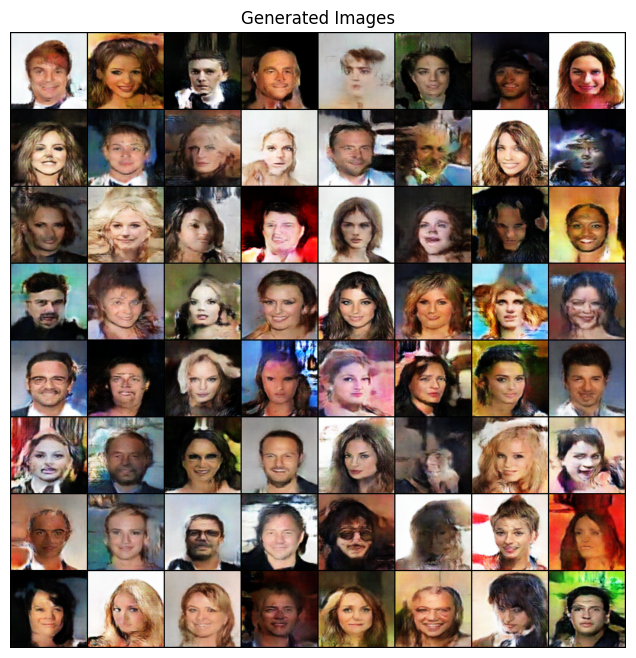

In [12]:
# Function to generate and visualize images
def generate_images(generator, latent_dim, num_images, device, save_path=None):
    # Set the generator to evaluation mode
    generator.eval()

    # Generate random noise vectors
    noise = torch.randn((num_images, latent_dim, 1, 1), device=device)

    # Generate fake images
    with torch.no_grad():  # No need to calculate gradients
        fake_images = generator(noise)

    # Normalize the images to [0, 1] for visualization
    fake_images = (fake_images + 1) / 2  # Since the generator outputs images in range [-1, 1]

    # Create a grid of images
    grid = vutils.make_grid(fake_images, nrow=8, normalize=True)

    # Visualize the images
    plt.figure(figsize=(8, 8))
    plt.imshow(grid.permute(1, 2, 0).cpu())  # Convert CHW to HWC for visualization
    plt.axis("off")
    plt.title("Generated Images")
    plt.show()

    
# Example usage
latent_dim = 128
num_images = 64
generate_images(G, latent_dim, num_images, device, save_path="generated_images.png")
